In [363]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram



In [253]:
data2 = pd.read_csv("data_exploration.csv")

# Segmentation RFM

## PCA 

In [254]:
data_pca1 = data2[['payment_value','fréquence','recence']]
data_pca1

payment_value  fréquence  recence
0             141.90          1      115
1              27.19          1      118
2              86.22          1      541
3              43.62          1      325
4             196.89          1      292
...              ...        ...      ...
94452        2067.42          1      451
94453          84.58          1      266
94454         112.46          1      572
94455         133.69          1      123
94456          71.56          1      488

[94457 rows x 3 columns]

In [255]:
X = data_pca1
keep_ind = X.index
X = StandardScaler().fit_transform(X)


In [256]:
n_components = 3
pca = PCA(n_components=n_components)

pca.fit(X)
var = pca.explained_variance_ratio_
var

array([0.37672456, 0.33304003, 0.29023541])

In [257]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([37.67, 33.3 , 29.02])

In [258]:
scree_cum = scree.cumsum().round()
scree_cum

array([ 38.,  71., 100.])

In [259]:
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3]

In [260]:
print (pca.explained_variance_ratio_)

[0.37672456 0.33304003 0.29023541]


In [261]:
print (pca.explained_variance_ratio_.cumsum())

[0.37672456 0.70976459 1.        ]


In [262]:
def create_pca_explained_variance_table(pca):
    var = pca.explained_variance_ratio_*100
    explained_variance_table = pd.DataFrame({'Composante principale': range(1, len(var)+1),
                                            'Pourcentage de variance expliquée': var})
    explained_variance_table['Pourcentage de variance expliquée cumulé'] = explained_variance_table['Pourcentage de variance expliquée'].cumsum()
    return explained_variance_table

In [263]:
create_pca_explained_variance_table(pca)

Composante principale  Pourcentage de variance expliquée  \
0                      1                          37.672456   
1                      2                          33.304003   
2                      3                          29.023541   

   Pourcentage de variance expliquée cumulé  
0                                 37.672456  
1                                 70.976459  
2                                100.000000

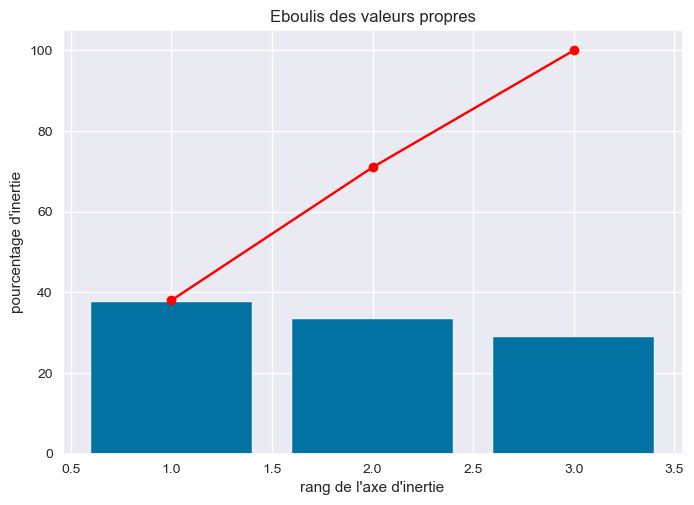

In [264]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [265]:
pcs = pca.components_
pcs

array([[ 0.69601693,  0.70577498, -0.13206857],
       [ 0.16737566,  0.01938866,  0.98570253],
       [-0.69824481,  0.70817071,  0.10463472]])

In [266]:
pcs = pd.DataFrame(pcs)
pcs

0         1         2
0  0.696017  0.705775 -0.132069
1  0.167376  0.019389  0.985703
2 -0.698245  0.708171  0.104635

In [267]:
features =['payment_value','fréquence','recence']

In [268]:
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

payment_value  fréquence  recence
F1           0.70       0.71    -0.13
F2           0.17       0.02     0.99
F3          -0.70       0.71     0.10

In [269]:
pcs.T

F1        F2        F3
payment_value  0.696017  0.167376 -0.698245
fréquence      0.705775  0.019389  0.708171
recence       -0.132069  0.985703  0.104635

In [270]:
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    #Titre
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

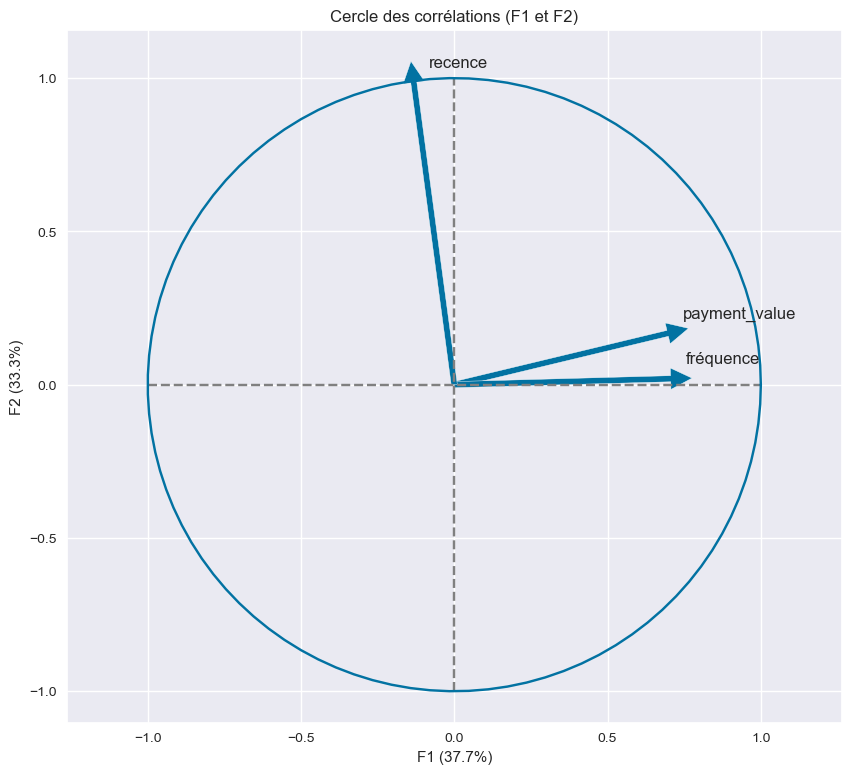

In [271]:
correlation_graph(pca,(0,1),features)

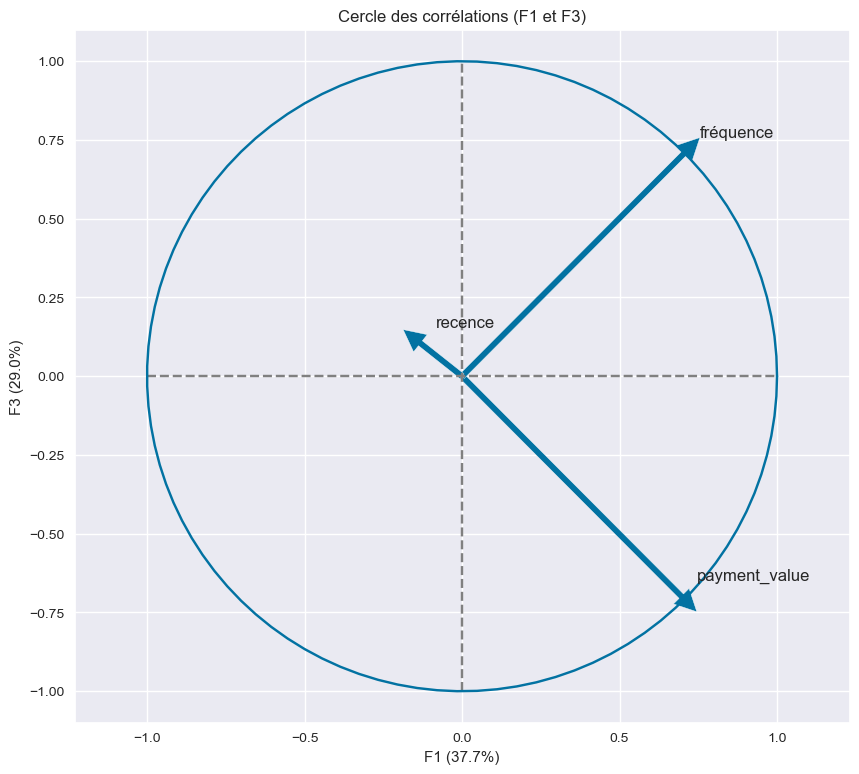

In [272]:
correlation_graph(pca,(0,2),features)

# T SNE

In [273]:
X_pca = data_pca1


In [274]:
tsne = TSNE(n_components=2)
T = tsne.fit_transform(X_pca.copy())

In [275]:
T

array([[ 21.45348 , -62.156197],
       [-97.63557 , -75.04591 ],
       [ 15.328492, 123.00298 ],
       ...,
       [ 40.09425 , 127.45477 ],
       [ 12.955967, -57.96457 ],
       [-11.889763, 110.21693 ]], dtype=float32)

C:\Users\boukh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Dimension 2')

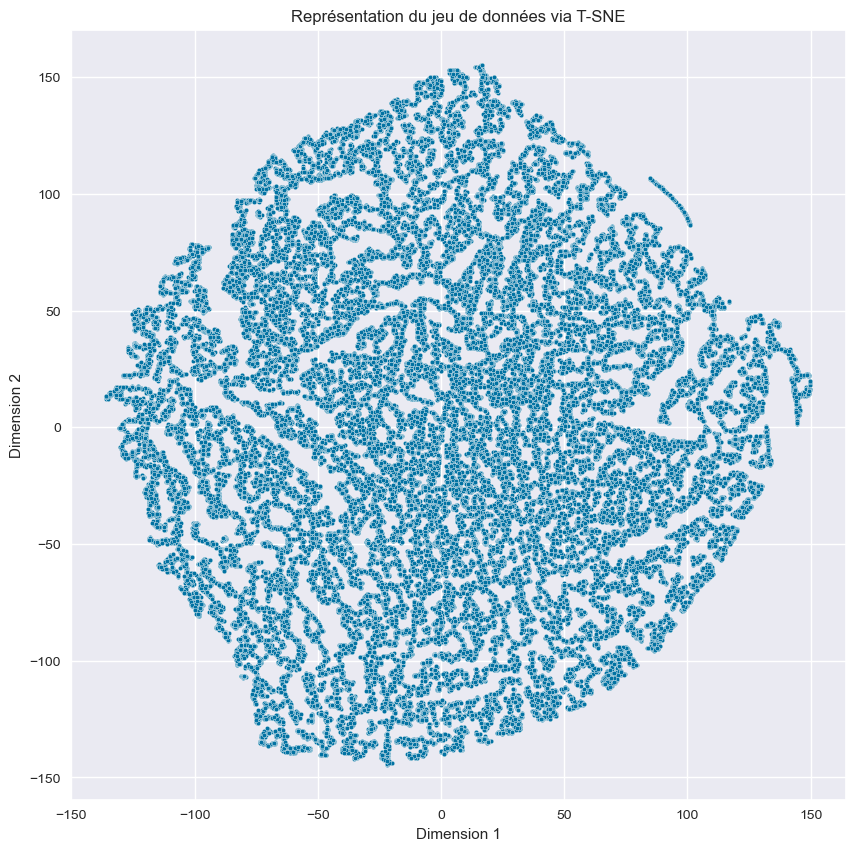

In [276]:
plt.figure(figsize=(10,10))
plt.title('Représentation du jeu de données via T-SNE')
sns.scatterplot(T[:,0], T[:,1],s=10)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

In [277]:
pca = PCA(n_components=2)

# Kmeans

In [278]:
datak = data2[['fréquence','payment_value','recence']]

In [279]:
def kmeans_cluster(df, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(df)
    df['cluster'] = kmeans.predict(df)
    return df

In [280]:
kmeansa = kmeans_cluster(datak,5)
kmeansa

C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\AppData\Local\Temp\ipykernel_7812\915648448.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.predict(df)


fréquence  payment_value  recence  cluster
0              1         141.90      115        1
1              1          27.19      118        1
2              1          86.22      541        0
3              1          43.62      325        0
4              1         196.89      292        0
...          ...            ...      ...      ...
94452          1        2067.42      451        2
94453          1          84.58      266        0
94454          1         112.46      572        0
94455          1         133.69      123        1
94456          1          71.56      488        0

[94457 rows x 4 columns]

In [281]:
def plot_kmeans(df, n_clusters):
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(df)
    df['cluster'] = kmeans.predict(df)
    
    # Perform PCA to reduce the dimensions of the data to 2D
    pca = PCA(n_components=2)
    df_2d = pca.fit_transform(df)
    
    # Plot the data points with different colors for each cluster
    plt.scatter(df_2d[:,0], df_2d[:,1], c=df['cluster'], cmap='viridis')
    plt.show()

C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\AppData\Local\Temp\ipykernel_7812\3961377517.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.predict(df)


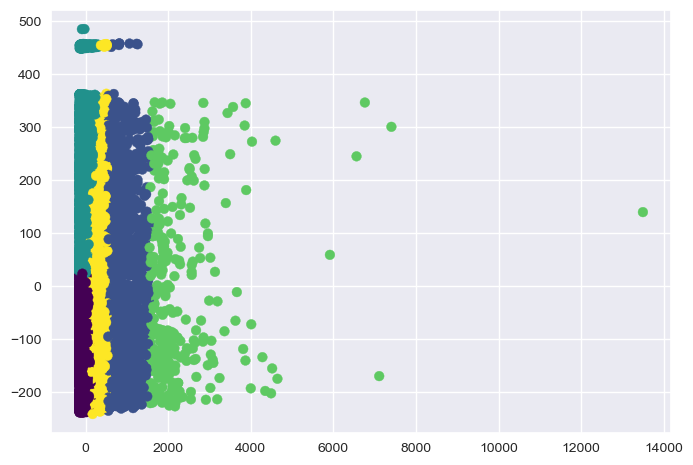

In [282]:
plot_kmeans(datak, 5)

In [283]:
def optimize_kmeans(X, max_clusters):
    sse = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)
        
    plt.plot(range(1, max_clusters + 1), sse)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Sum of Squared Errors (SSE)")
    plt.title("Elbow Method for Optimal K")
    plt.show()
    return


C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\clust

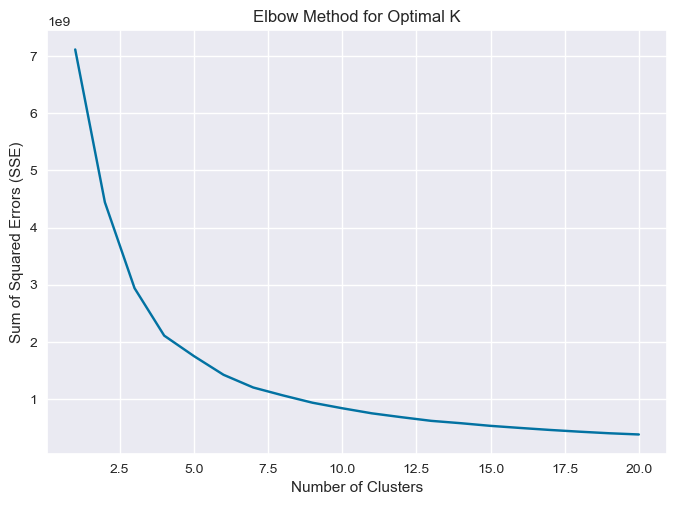

In [284]:
optimize_kmeans(datak, 20)

C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\clust

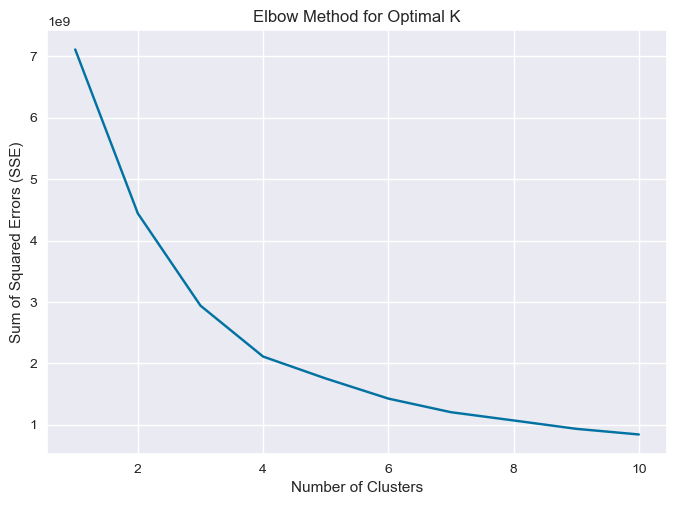

In [285]:
optimize_kmeans(datak, 10)

In [286]:
def analyse_silhouette(X2, n_clusters_liste):

    meilleur_score_silhouette = -1
    meilleur_n_clusters = -1
    
    for n_clusters in n_clusters_liste:
        # Créer une instance de KMeans
        kmeans = KMeans(n_clusters=n_clusters)
        
        # Ajuster le modèle KMeans aux données
        kmeans.fit(X2)
        
        # Prédire les étiquettes de cluster pour chaque point de données
        étiquettes = kmeans.labels_
        
        # Calculer le score de silhouette pour le modèle
        score_silhouette = silhouette_score(X2, étiquettes)
        
        # Mettre à jour le meilleur score de silhouette et le nombre de clusters si le score actuel est meilleur
        if score_silhouette > meilleur_score_silhouette:
            meilleur_score_silhouette = score_silhouette
            meilleur_n_clusters = n_clusters
    
    return meilleur_n_clusters, meilleur_score_silhouette

In [287]:
# Extraire les valeurs des caractéristiques sous forme de tableau numpy
X2 = datak.values

# Définir la plage de nombres de clusters à tester
n_clusters_liste = range(2, 8)

# Effectuer l'analyse de la silhouette
meilleur_n_clusters, meilleur_score_silhouette = analyse_silhouette(X2, n_clusters_liste)

print("Meilleur nombre de clusters: {}".format(meilleur_n_clusters))
print("Meilleur score de silhouette: {:.3f}".format(meilleur_score_silhouette))

C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\clust

Meilleur nombre de clusters: 2
Meilleur score de silhouette: 0.735


## Score elbow 


C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\clust

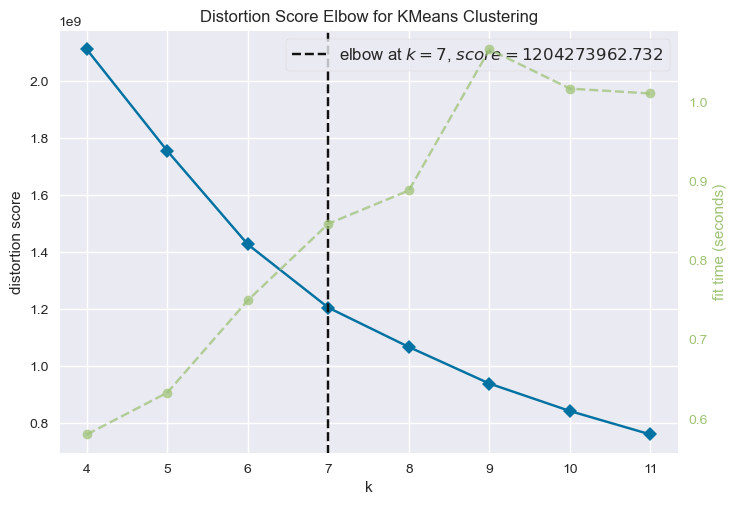

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [288]:
# Instantiate the clustering model and visualizer
model = KMeans(5)
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(X_pca)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [289]:
model = KMeans(5, random_state=42)


C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


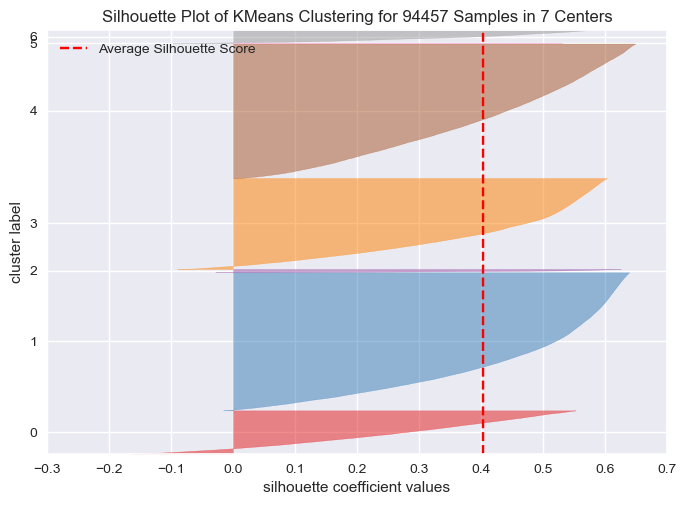

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 94457 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [290]:
# Instantiate the clustering model and visualizer 
model = KMeans(7)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_pca)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


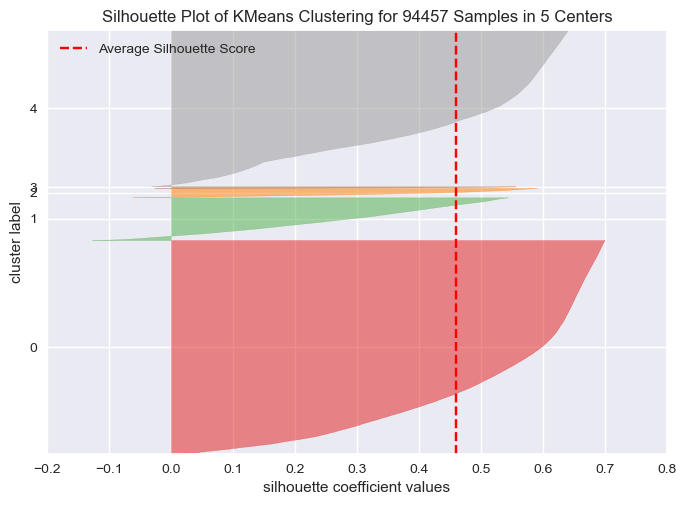

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 94457 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [291]:
# Instantiate the clustering model and visualizer 
model = KMeans(5)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_pca)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


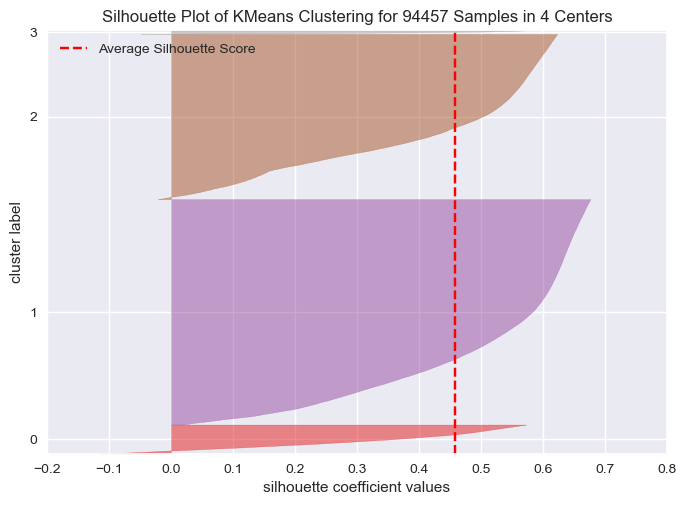

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 94457 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [292]:
# Instantiate the clustering model and visualizer 
model = KMeans(4)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_pca)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


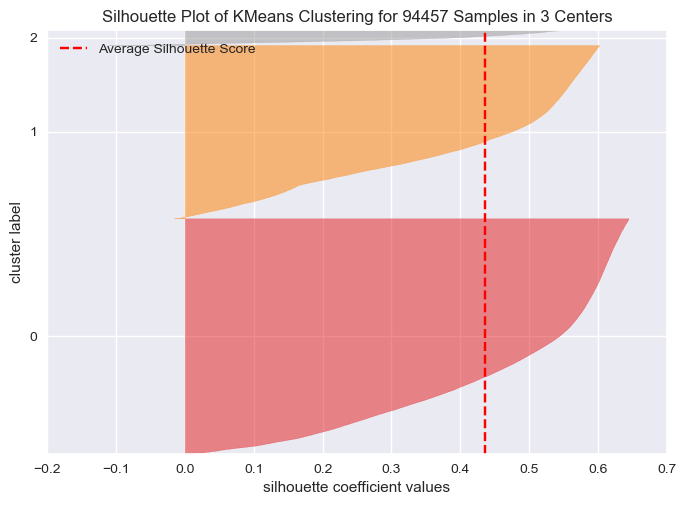

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 94457 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [293]:
# Instantiate the clustering model and visualizer 
model = KMeans(3)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_pca)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [294]:
kb = kmeans_cluster(datak,5)

C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\AppData\Local\Temp\ipykernel_7812\915648448.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.predict(df)


In [295]:
res_clusters_rfm  = kb.groupby(['cluster']).agg({
        'recence': 'mean',
        'fréquence': 'mean',
        'payment_value': ['mean', 'count']
    }).round(0)
res_clusters_rfm

recence fréquence payment_value       
           mean      mean          mean  count
cluster                                       
0         133.0       1.0         108.0  47810
1         248.0       1.0         999.0   2089
2         398.0       1.0         111.0  34703
3         233.0       1.0        2402.0    339
4         224.0       1.0         400.0   9516

## DBSCAN

In [296]:
!pip install kneed

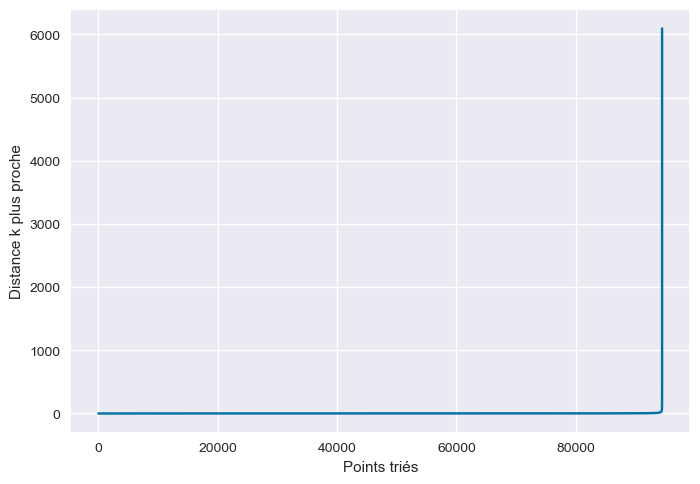

In [297]:

from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Calcul des distances des k voisins les plus proches
neigh = NearestNeighbors(n_neighbors=10)
nbrs  = neigh.fit(X_pca)
distances, indices = nbrs.kneighbors(X_pca)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# Tracé de la courbe de décision
plt.plot(distances);
plt.xlabel('Points triés')
plt.ylabel('Distance k plus proche')
plt.show()



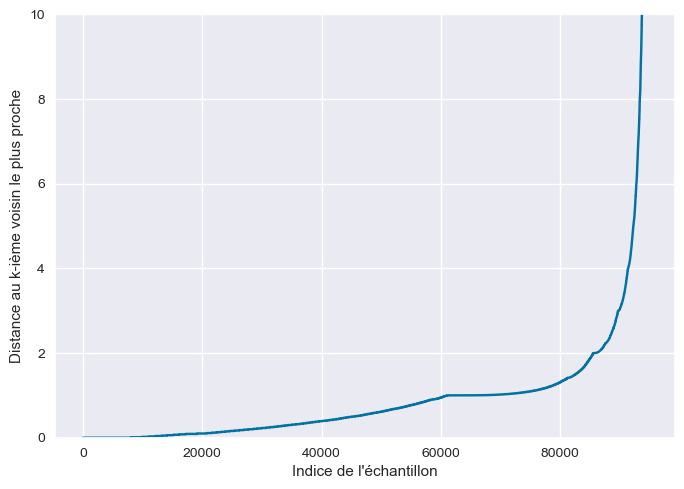

In [298]:
plt.plot(distances)
plt.ylim([0, 10]) # Ajuster les limites de l'axe des ordonnées pour zoomer sur la partie intéressante de la courbe
plt.xlabel('Indice de l\'échantillon')
plt.ylabel('Distance au k-ième voisin le plus proche')
plt.show()


In [299]:
dbs = DBSCAN(eps = 3, 
             min_samples=5,
               n_jobs=-1).fit(X_pca.copy())

C:\Users\boukh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Représentation de la séparation des données du DBSCAN via T-SNE'}>

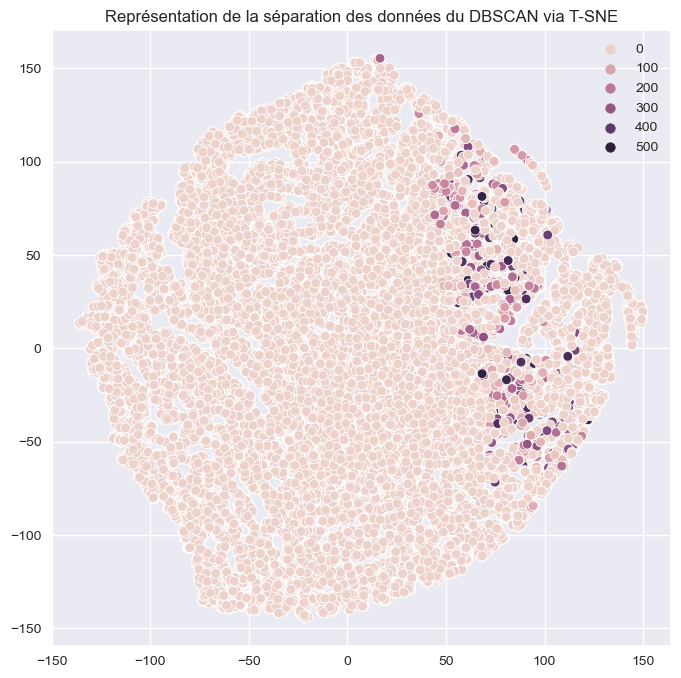

In [300]:
plt.figure(figsize=(8,8))
plt.title('Représentation de la séparation des données du DBSCAN via T-SNE')
sns.scatterplot(T[:,0], T[:,1], dbs.labels_)

In [ ]:
# Calcul du score de silhouette
silhouette_avg = silhouette_score(T[:,0], T[:,1], dbs.labels_)
print("Score de silhouette pour DBSCAN :", silhouette_avg)

In [340]:
silhouette_avg

0.813950963970275

## Segmentation RFM avec la satisfaction 

In [301]:
data_pca0 = data2[['payment_value','review_score','fréquence','recence']]

In [302]:
X = data_pca0
keep_ind = X.index
X = StandardScaler().fit_transform(X)


In [303]:
n_components = 4
pca = PCA(n_components=n_components)

pca.fit(X)
var = pca.explained_variance_ratio_
var

array([0.28357861, 0.2568314 , 0.24444732, 0.21514267])

In [304]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([28.36, 25.68, 24.44, 21.51])

In [305]:
scree_cum = scree.cumsum().round()
scree_cum

array([ 28.,  54.,  78., 100.])

In [306]:
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4]

In [307]:
print (pca.explained_variance_ratio_)

[0.28357861 0.2568314  0.24444732 0.21514267]


In [308]:
print (pca.explained_variance_ratio_.cumsum())

[0.28357861 0.54041001 0.78485733 1.        ]


In [309]:
create_pca_explained_variance_table(pca)

Composante principale  Pourcentage de variance expliquée  \
0                      1                          28.357861   
1                      2                          25.683140   
2                      3                          24.444732   
3                      4                          21.514267   

   Pourcentage de variance expliquée cumulé  
0                                 28.357861  
1                                 54.041001  
2                                 78.485733  
3                                100.000000

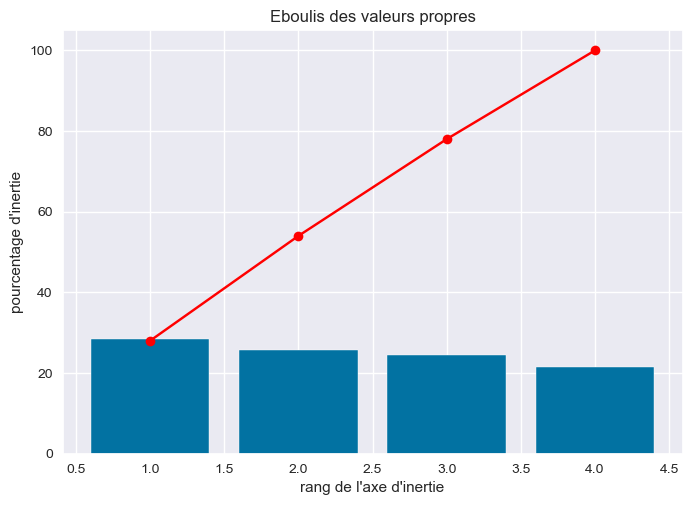

In [310]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [311]:
features =['payment_value','review_score','order_id','recence']

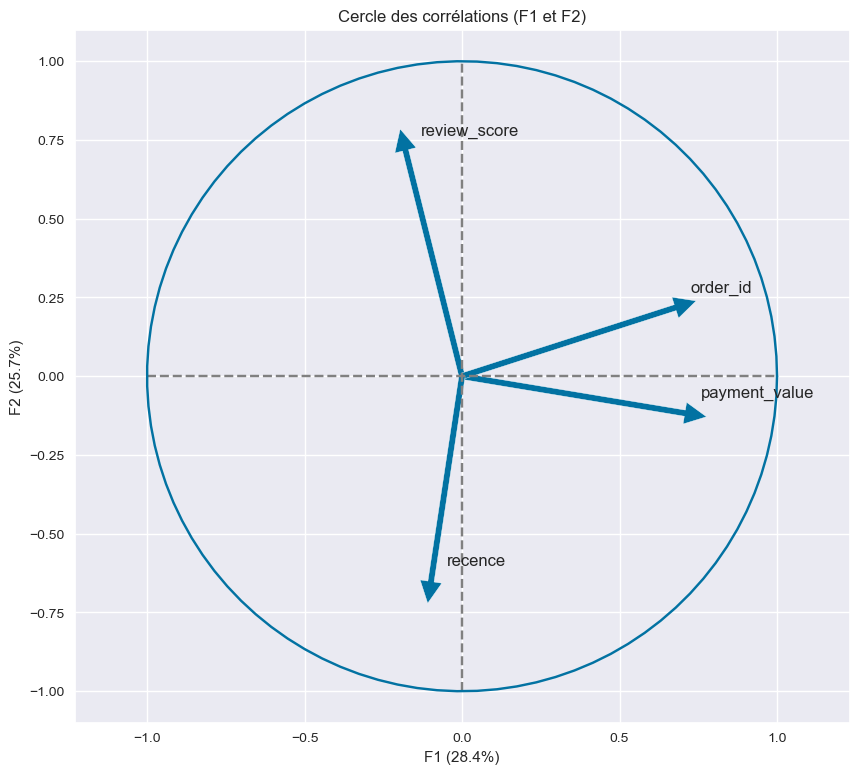

In [312]:
correlation_graph(pca,(0,1),features)

Réduire la dimensionalité des données, c'est-à-dire le nombre de variables utilisées pour les représenter, permet :

- de faciliter la visualisation des données ;

- de réduire les coûts de calcul, de stockage et d'acquisition des données ;

- d'améliorer l'apprentissage en construisant des modèles moins complexes, en éliminant les variables non pertinentes qui pourraient fausser les prédictions et enfin en réduisant le problème du fléau de la dimensionalité.

In [358]:
X_pca0 = data_pca0

In [359]:
tsne = TSNE(n_components=2)
T = tsne.fit_transform(X_pca0.copy())

C:\Users\boukh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Dimension 2')

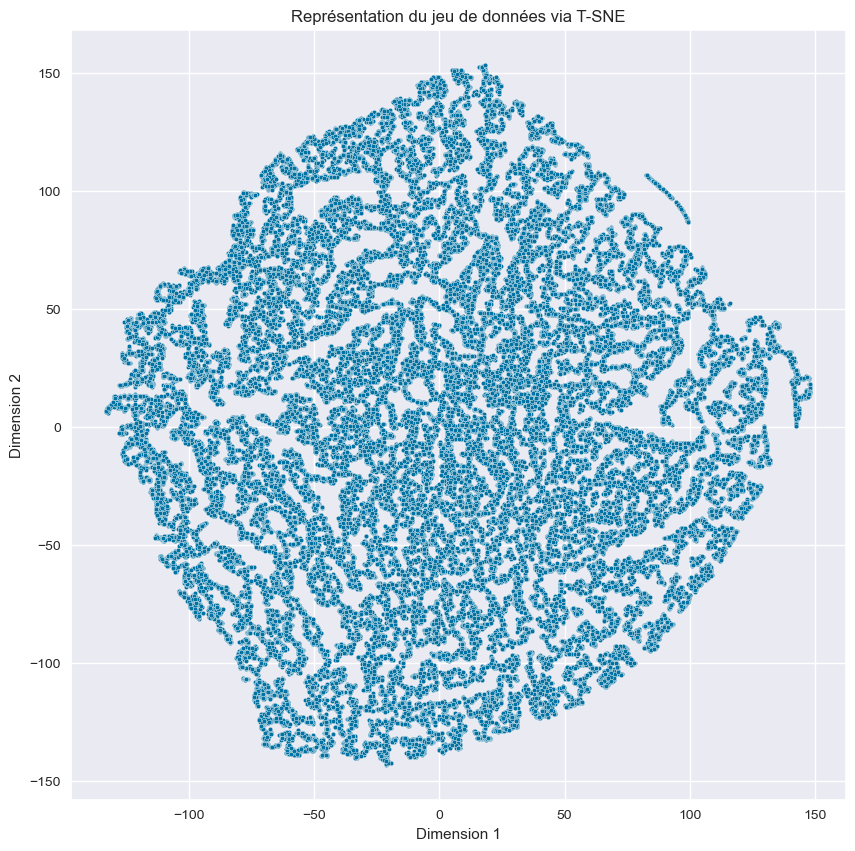

In [315]:
plt.figure(figsize=(10,10))
plt.title('Représentation du jeu de données via T-SNE')
sns.scatterplot(T[:,0], T[:,1],s=10)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Kmeans

In [316]:
datak2 = data2[['fréquence','payment_value','recence','review_score']]

In [317]:
kmeans1 = kmeans_cluster(datak2,5)

C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\AppData\Local\Temp\ipykernel_7812\915648448.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.predict(df)


C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\AppData\Local\Temp\ipykernel_7812\3961377517.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.predict(df)


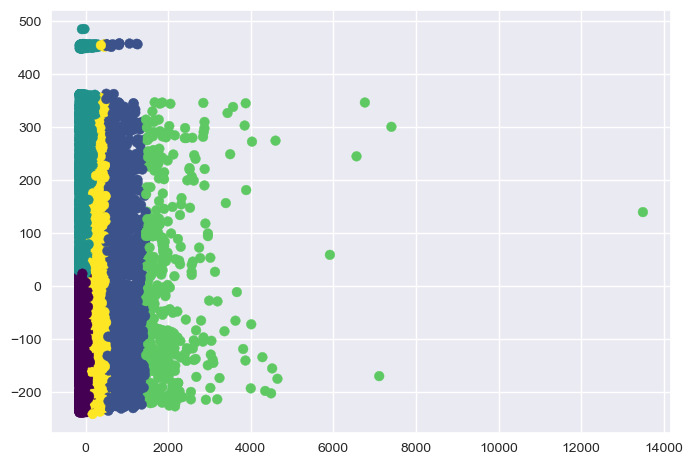

In [318]:
plot_kmeans(datak2, 5)

C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\clust

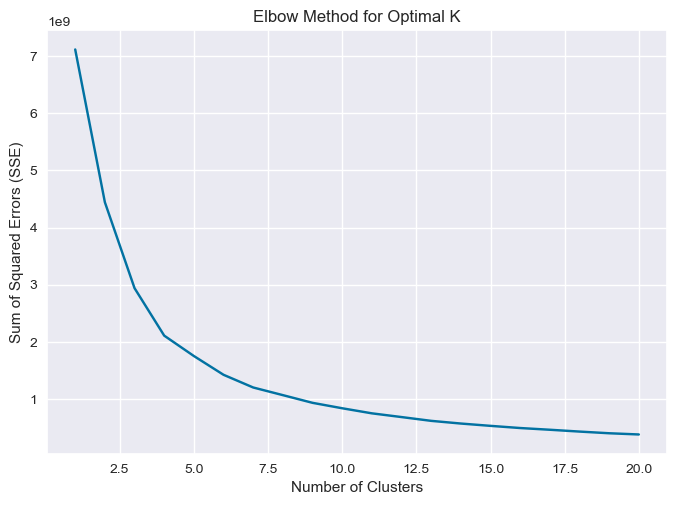

In [319]:
optimize_kmeans(datak2, 20)

C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\clust

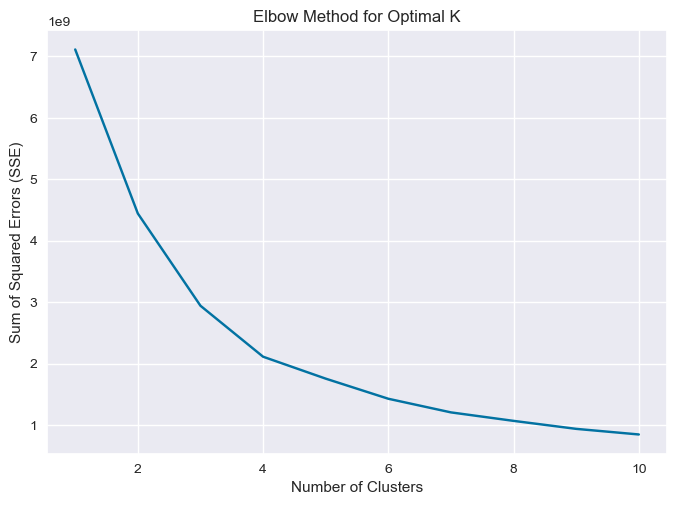

In [320]:
optimize_kmeans(datak2, 10)

In [321]:
# Extraire les valeurs des caractéristiques sous forme de tableau numpy
X2 = datak2.values

# Définir la plage de nombres de clusters à tester
n_clusters_liste = range(2, 8)

# Effectuer l'analyse de la silhouette
meilleur_n_clusters, meilleur_score_silhouette = analyse_silhouette(X2, n_clusters_liste)

print("Meilleur nombre de clusters: {}".format(meilleur_n_clusters))
print("Meilleur score de silhouette: {:.3f}".format(meilleur_score_silhouette))

C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\clust

Meilleur nombre de clusters: 2
Meilleur score de silhouette: 0.735


## Score Elbow

C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\anaconda3\lib\site-packages\sklearn\clust

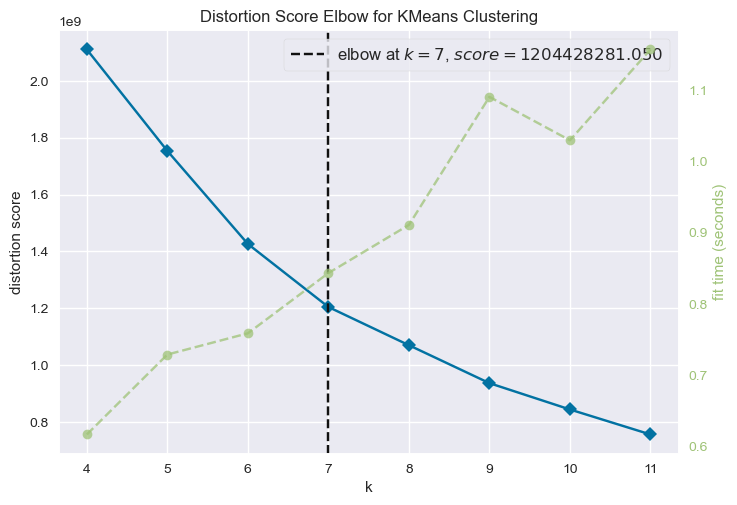

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [322]:
# Instantiate the clustering model and visualizer
model = KMeans(5)
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(X_pca0)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [323]:
model = KMeans(5, random_state=42)

C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


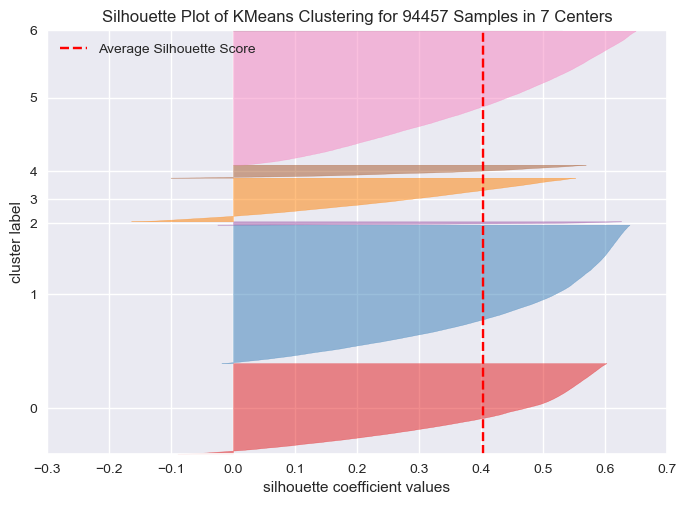

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 94457 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [324]:
# Instantiate the clustering model and visualizer 
model = KMeans(7)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_pca0)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


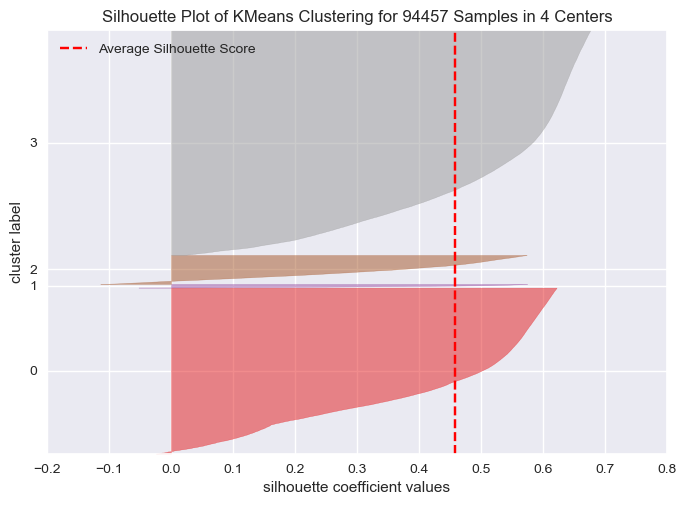

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 94457 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [325]:
# Instantiate the clustering model and visualizer 
model = KMeans(4)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_pca0)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


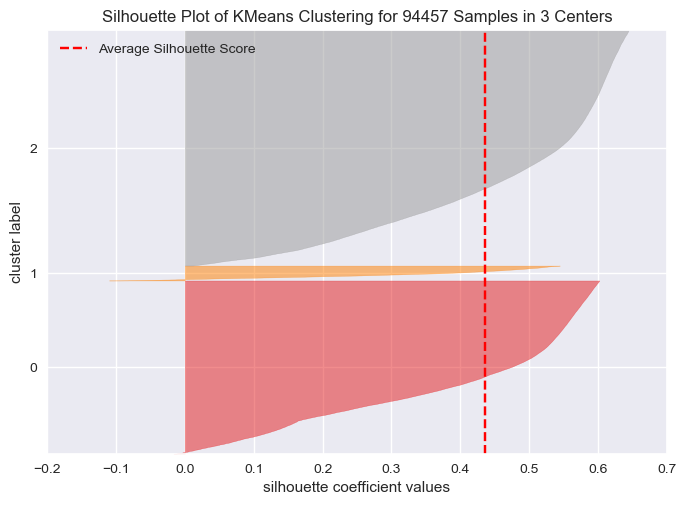

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 94457 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [326]:
# Instantiate the clustering model and visualizer 
model = KMeans(3)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_pca0)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


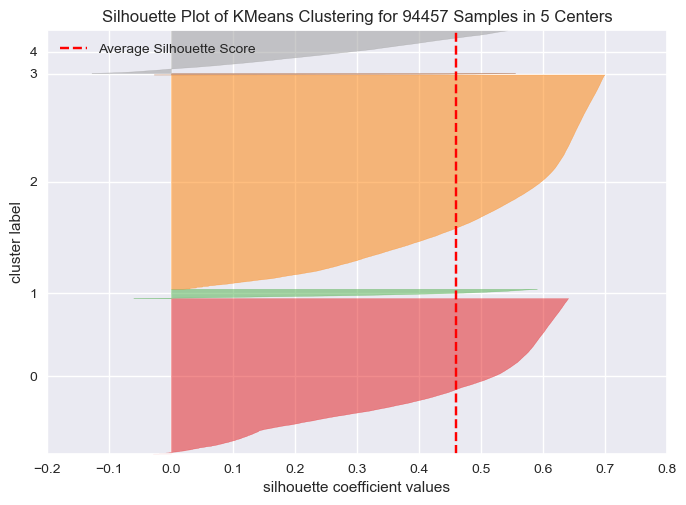

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 94457 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [327]:
# Instantiate the clustering model and visualizer 
model = KMeans(5)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_pca0)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

5 clusters me parait etre le plus conforme

In [328]:
kb = kmeans_cluster(datak2,5)

C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\boukh\AppData\Local\Temp\ipykernel_7812\915648448.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.predict(df)


In [329]:
kb

fréquence  payment_value  recence  review_score  cluster
0              1         141.90      115           5.0        1
1              1          27.19      118           4.0        1
2              1          86.22      541           3.0        0
3              1          43.62      325           4.0        0
4              1         196.89      292           5.0        0
...          ...            ...      ...           ...      ...
94452          1        2067.42      451           5.0        4
94453          1          84.58      266           4.0        0
94454          1         112.46      572           5.0        0
94455          1         133.69      123           5.0        1
94456          1          71.56      488           5.0        0

[94457 rows x 5 columns]

In [330]:
res_clusters_rfm  = kb.groupby(['cluster']).agg({
        'recence': 'mean',
        'fréquence': 'mean',
        'payment_value': ['mean', 'count'],
        'review_score' : 'mean'
    }).round(0)

res_clusters_rfm

recence fréquence payment_value        review_score
           mean      mean          mean  count         mean
cluster                                                    
0         398.0       1.0         111.0  34702          4.0
1         133.0       1.0         108.0  47811          4.0
2         248.0       1.0         999.0   2089          4.0
3         224.0       1.0         400.0   9516          4.0
4         233.0       1.0        2402.0    339          4.0

- Cluster 0 : Clients anciens ayant passé énormément de commandes à faible coût.
- Cluster 1 : Clients très récents ayant passé énormément de commandes à faible coût.
- Cluster 2 : Clients récents ayant passé peu de commandes à prix élevé.
- Cluster 3 : Clients récents ayant passé beaucoup de commandes à prix moyen.
- Cluster 4 : Clients récents ayant passé très peu de commandes à prix très élevé.

In [361]:
XX = datak.values

In [365]:
kmeanss = KMeans(n_clusters=5)

In [366]:
kmeanss.fit(XX)

C:\Users\boukh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5)

In [367]:
labels = kmeanss.labels_

In [368]:
silhouette_score(XX, labels)

0.46018469002479584

### TSNE avec kmeans cluster 

C:\Users\boukh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


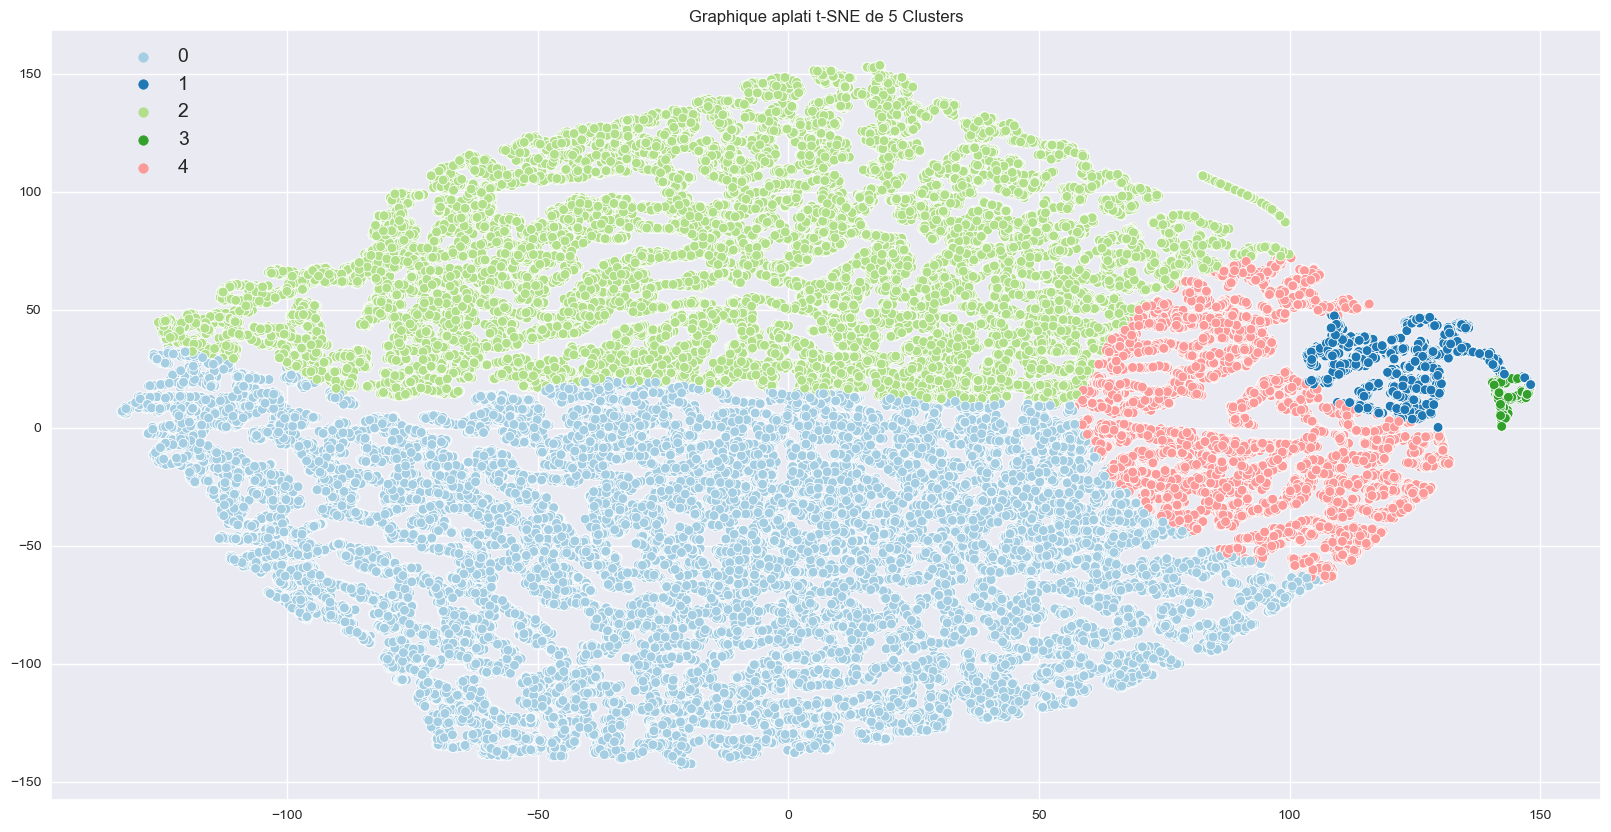

In [331]:

plt.figure(figsize=(20, 10))
sns.set_style('darkgrid')
colors = sns.color_palette('Paired', n_colors=5)
cluster = datak['cluster'].to_list()
plt.title('Graphique aplati t-SNE de 5 Clusters')
sns.scatterplot(T[:,0], T[:,1],
                hue=cluster, palette=colors)
plt.legend(bbox_to_anchor=(0.1, 1), loc=0,
           fontsize=14)
plt.show()

## DBSCAN

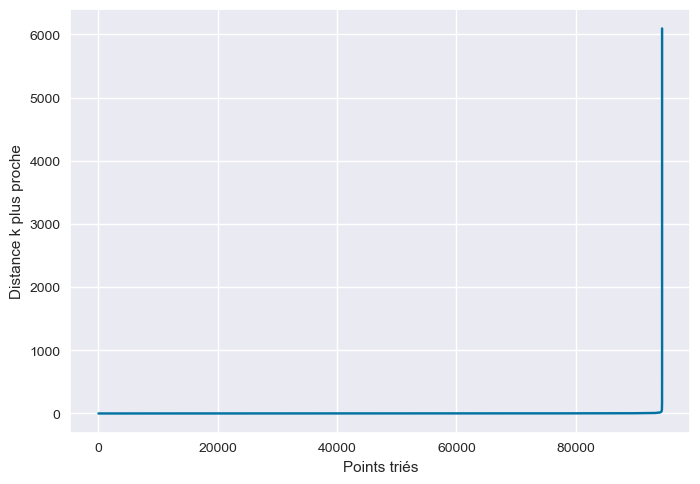

In [342]:
# Calcul des distances des k voisins les plus proches
neigh = NearestNeighbors(n_neighbors=10)
nbrs  = neigh.fit(X_pca0)
distances, indices = nbrs.kneighbors(X_pca0)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# Tracé de la courbe de décision
plt.plot(distances);
plt.xlabel('Points triés')
plt.ylabel('Distance k plus proche')
plt.show()

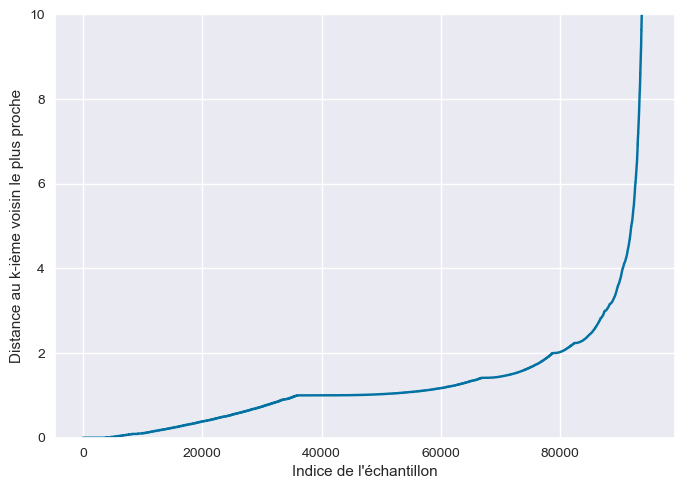

In [343]:
plt.plot(distances)
plt.ylim([0, 10]) # Ajuster les limites de l'axe des ordonnées pour zoomer sur la partie intéressante de la courbe
plt.xlabel('Indice de l\'échantillon')
plt.ylabel('Distance au k-ième voisin le plus proche')
plt.show()


In [345]:
dbs = DBSCAN(eps = 3.5, 
             min_samples=5,
               n_jobs=-1).fit(X_pca0.copy())

C:\Users\boukh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Représentation de la séparation des données du DBSCAN via T-SNE'}>

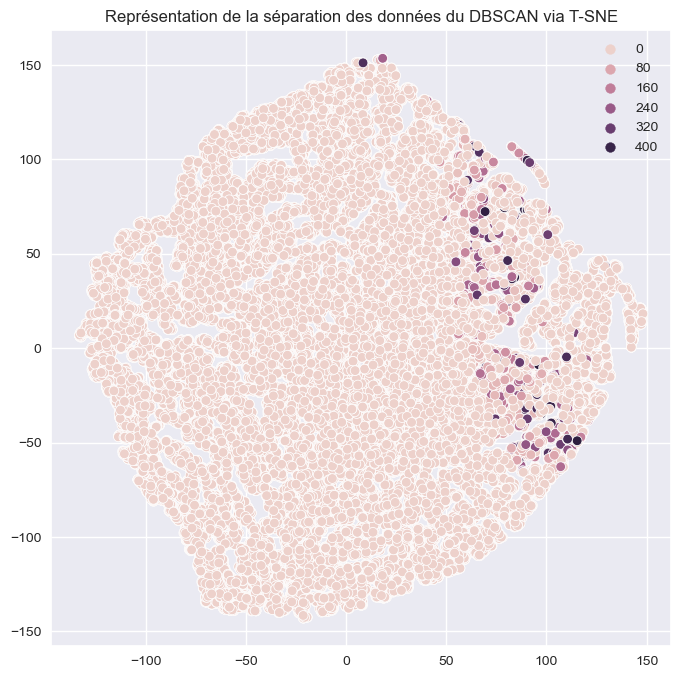

In [346]:
plt.figure(figsize=(8,8))
plt.title('Représentation de la séparation des données du DBSCAN via T-SNE')
sns.scatterplot(T[:,0], T[:,1], dbs.labels_)

## Dendogramme 

C:\Users\boukh\AppData\Local\Temp\ipykernel_7812\1296472577.py:29: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(square_distance_matrix, method='single')


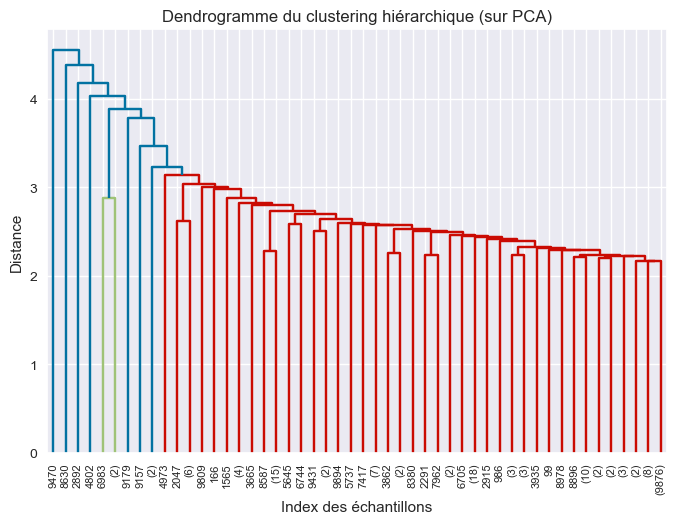

In [356]:

# Charger ou créer votre DataFrame nommé darak2
# Remplacer cette partie par le chargement ou la création de votre propre DataFrame
datak2 = {
    'fréquence': np.random.rand(10000),
    'payment_value': np.random.rand(10000),
    'recence': np.random.rand(10000),
    'review_score': np.random.rand(10000),
}
datak2 = pd.DataFrame(datak2)

# Effectuer la PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(datak2)

# Calculer la matrice de distances
distance_matrix = pdist(reduced_data, metric='euclidean')

# Convertir la matrice de distances en une matrice carrée
square_distance_matrix = squareform(distance_matrix)

# Effectuer le clustering hiérarchique agglomératif
Z = linkage(square_distance_matrix, method='single')

# Afficher le dendrogramme (avec un sous-ensemble des échantillons pour une meilleure visibilité)
plt.figure()
dendrogram(Z, truncate_mode='lastp', p=50)
plt.xlabel('Index des échantillons')
plt.ylabel('Distance')
plt.title('Dendrogramme du clustering hiérarchique (sur PCA)')
plt.show()


In [332]:
data2

Unnamed: 0                customer_unique_id  fréquence  \
0               0  0000366f3b9a7992bf8c76cfdf3221e2          1   
1               1  0000b849f77a49e4a4ce2b2a4ca5be3f          1   
2               2  0000f46a3911fa3c0805444483337064          1   
3               3  0000f6ccb0745a6a4b88665a16c9f078          1   
4               4  0004aac84e0df4da2b147fca70cf8255          1   
...           ...                               ...        ...   
94452       94452  fffcf5a5ff07b0908bd4e2dbc735a684          1   
94453       94453  fffea47cd6d3cc0a88bd621562a9d061          1   
94454       94454  ffff371b4d645b6ecea244b27531430a          1   
94455       94455  ffff5962728ec6157033ef9805bacc48          1   
94456       94456  ffffd2657e2aad2907e67c3e9daecbeb          1   

      order_purchase_timestamp  payment_installments  payment_value  \
0          2018-05-10 10:56:27                     8         141.90   
1          2018-05-07 11:11:27                     1          27.19   
2          2017-03-10 21:05:03                     8          86.22   
3          2017-10-12 20:29:41                     4          43.62   
4          2017-11-14 19:45:42                     6         196.89   
...                        ...                   ...            ...   
94452      2017-06-08 21:00:36                    10        2067.42   
94453      2017-12-10 20:07:56                     1          84.58   
94454      2017-02-07 15:49:16                     1         112.46   
94455      2018-05-02 15:17:41                     5         133.69   
94456      2017-05-02 20:18:45                     4          71.56   

       review_score customer_state payment_type  produit total  recence  \
0               5.0             SP  credit_card             66      115   
1               4.0             SP  credit_card            144      118   
2               3.0             SC  credit_card            117      541   
3               4.0             PA  credit_card             32      325   
4               5.0             SP  credit_card            133      292   
...             ...            ...          ...            ...      ...   
94452           5.0             PE  credit_card             28      451   
94453           4.0             BA  credit_card             72      266   
94454           5.0             MT  credit_card             55      572   
94455           5.0             ES  credit_card             40      123   
94456           5.0             PR  credit_card             12      488   

      month_col  
0       2018-05  
1       2018-05  
2       2017-03  
3       2017-10  
4       2017-11  
...         ...  
94452   2017-06  
94453   2017-12  
94454   2017-02  
94455   2018-05  
94456   2017-05  

[94457 rows x 12 columns]

In [333]:
data_maintenance = data2[['customer_unique_id',"recence","fréquence", "payment_value","review_score", "order_purchase_timestamp"]]


In [334]:
data_maintenance.to_csv("data_maintenance.csv")